<a href="https://colab.research.google.com/github/woo2201/ColabDrive/blob/reservior/AB_Test_forCompany.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h2>빈도주의에 기초한 기본 가설검정 방법론<h2\>



1. 간단한 T - test 입니다.
T - test 의 목적은 다른 두 동질 집단의 평균 비교입니다. 

In [1]:
from scipy import stats
import random

# generate a random list from which you gonna extract a sublist.
randomlist = [round(random.uniform(10.5, 25.5),5) for i in range(0, 100)] 

group_A = random.choices(randomlist, k = 24) # A group has 24 samples
group_B = random.choices(randomlist, k = 28) # A group has 28 samples

stats.ttest_ind(group_A,
                group_B,
                equal_var = False) # can't assume equal variance cuz I just random sampled. This "equal_var = False" equals to Welch's t-test. 
                                   # 실무에서 수집한 데이터의 분산이 같기는 드물 뿐더러 수집 데이터의 갯수가 같은 경우는 더욱 드물기 때문입니다.

Ttest_indResult(statistic=2.1048317849709877, pvalue=0.04049891370679466)


```python
Ttest_indResult(statistic = -1.5887136398548387,
                pvalue = 0.11851296053114146)
```

P - value 가 0.05 수준에서 유의하지 않습니다.
바꿔 말하면, 우연에 의해 나타난 효과일 가능성이 있다는 (11% 정도) 이야기입니다.
동일한 기준으로 uniformly distributed 된 데이터셋에서 산출된 데이터니 당연한 결과겠네요.

✅ 테스트 설정값 중 : ``` equal_var = True ``` 으로 설정된 부분이 있는데, 이 부분의 의미하는 바는 등분산 가정(homoskedacity)을 가정하지 않는 Welch's T-test 로 테스트를 하겠다는 의미입니다. 실제 세상에서는 데이터의 분산이 같기 힘들 뿐더러, 갯수도 같지 않은 경우가 많습니다.

이를 고려해서 Welch's T-test로 테스트를 합니다.


- 또한 위의 T test는 평균간의 비교입니다. 바꿔 말하면, 연속형 변수들의 평균 비교밖에 유효하지 않다는 이야기입니다. 그렇다면 명목형/범주형 변수들의 (예를 들자면, 청약 여부) 비교는 어떻게 해야할까요? 예를 들어 이번 보따리 실험과 같이 말입니다.

- 아래서 소개하는 방식은 카이스퀘어 방식입니다.

In [ ]:
import pandas as pd
from scipy.stats import chi2_contingency

def click_abtest(a_Yes, a_Tot, b_Yes, b_Tot):

    agreed = [a_Yes, b_Yes] 
    disagreed = [a_Tot - a_Yes, b_Tot - b_Yes] 
    cont_table = pd.DataFrame([agreed, disagreed], columns=['A', 'B'], index=['agreed', 'disagreed'])
    chi2, p_val, d_f, expected = chi2_contingency([agreed, disagreed])

    print("Chi-square Value :", format(chi2, '.6f'))
    print("p_value :", format(p_val, '.6f'))

click_abtest(13, 244, 23, 287)

Chi-square Value : 1.110527
p_value : 0.291967


```python
Chi-square Value : 1.110527
p_value : 0.291967
```

기각해야겠네요.


<h2> 검정력 테스트 </h2>

- 이 모든 테스트에 앞서서, 우리가 하나 잊어먹은게 있습니다. 
- 실제 세계에서는 표본을 무제한으로 모을 수는 없습니다. 무제한으로 모아도 p-value 가 무한정 낮아지는 오류가 발생하고요.

- 그런 의미에서, 일단 얼마만큼의 표본이 필요한지에 대한 기준이 필요합니다.

In [10]:
# estimate sample size via power analysis
from statsmodels.stats.power import TTestIndPower

effect = 0.06 # Cohen's d measure 로 측정하는 effective effect size 의 크기는 0.8 <= 정도라고 합니다. 이게 낮아질 수록 필요 샘플사이즈는 올라갑니다.  집단간 평균 차이가 크다는 건, 효과크기가 크다는걸 의미합니다.
alpha = 0.05 # 유의수준입니다.
power = 0.8 # 원하는 검정력 수치입니다. 
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=1.0, alpha=alpha)
print('Sample Size: %.3f' % result)

Sample Size: 4361.439


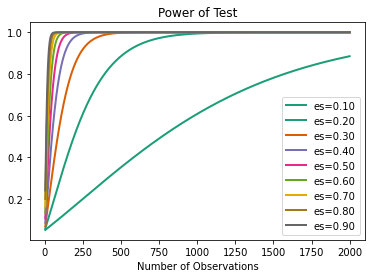

In [20]:
# calculate power curves for varying sample and effect size
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect_sizes = np.arange(0.1, 1, 0.1)
sample_sizes = np.array(range(5, 2000))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var = 'nobs',
                    nobs = sample_sizes,
                    effect_size = effect_sizes)
plt.show()

이펙트 사이즈가 아무리 적더라도, 사실 0.8 까지의 검정력을 확보하는데 있어서는 1700 선까지만 모으면 됬던 것.